# LE Shifts and Lags using covariates and model averaging (stacking)

## Some definitions

- Define set of priors (for reproducibility)
     - I am using `prior = set_prior("normal(0, 5)", class = "b")` for all betas.
     - 2000 iterations and 2 chains
- Set seed: 850091718

## Nomenclature

- m1 = LE 1900 models
- m2 = LE 1950 models
- m3 = Cause of death 1900 models
- m4 = Cause of death 1950 models

In [1]:
library(here)
library(haven)
library(sdazar)
library(data.table)
library(ggplot2)
library(stringr)
library(brms)
options(mc.cores = parallel::detectCores()-2)
library(imputeTS)
# library(stringr)
# library(ggridges)
# library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)
library(texreg)
seed = 850091718

here() starts at /Users/sebastiandaza/Documents/papers/lambda
Loading required package: data.table
Loading required package: knitr
Loading required package: miceadds
Loading required package: mice
Loading required package: lattice
* miceadds 2.10-14 (2018-03-29 14:47:31)
Loading required package: Rcpp
Loading 'brms' package (version 2.5.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.

Attaching package: ‘brms’

The following object is masked from ‘package:sdazar’:

    mi

Version:  1.36.23
Date:     2017-03-03
Author:   Philip Leifeld (University of Glasgow)

Please cite the JSS article in your publications -- see citation("texreg").


In [2]:
# functions 
source('functions.R')

In [3]:
# load data
df = data.table(read_stata('../data/Ex_LA1850-2013_SES_ABBREVIATED_april-3-2018.dta'))

country_labels = c("Argentina", "Bolivia", "Brazil", "Chile", "Colombia", 
                   "Costa_Rica", "Cuba", "Dominican_Republic", "Ecuador", 
                   "El_Salvador", "Guatemala", "Honduras", "Mexico", "Nicaragua", 
                   "Panama", "Paraguay", "Peru", "Uruguay", "Venezuela")

df[, ctry := factor(ctry, labels=country_labels)]

# Only male-female average and records since 1900

In [4]:
# covariates = names(df)[10:28]
# print(covariates)
covariates = c("gdp_pc", "urban", "elec", "lit" ,"water" ,"sewage" ,"gini" ,
               "tfr" ,"bf" ,"extFund" ,"healthGdp" ,"lsi" ,"polio" ,"bcg" ,"dpt1" ,"dpt3" ,"mcv1" ,
               "us_aid" ,"lunion")
# life expectancy 0, tseries == 2 

c = df[tseries2==1 & age==0 & year>=1900, lapply(.SD,Max), 
       .SDcols=covariates, by=.(ctry, year)]

le = df[tseries2==1 & age==0 & year>=1900, .(Ex=Mean(Ex)), by=.(ctry, year)]

# check
# (nrow(c) + nrow(le))/2

dt = merge(c, le, by=c('ctry', 'year'))

# missing data
print(countmis(dt))

       bf      elec       lsi       lit   extFund      gini     water    sewage 
    0.977     0.951     0.922     0.852     0.844     0.820     0.775     0.773 
healthGdp     polio       bcg      dpt1      dpt3      mcv1     urban       tfr 
    0.709     0.681     0.681     0.681     0.681     0.681     0.451     0.445 
   us_aid    gdp_pc 
    0.360     0.103 


### Define dataset

In [5]:
test = dt[year>=1900, .(ctry, year, gdp_pc, urban, lit, Ex, water, sewage, elec, us_aid, tfr)]

In [6]:
# year recode based on the criteria proposed by Alberto
test[year<1950, gyear:='1950']
test[year>=1950 & year<1970, gyear:='1950-1969']
test[year>=1970 & year<1990, gyear:='1970-1989']
test[year>=1990, gyear :='1990']
# # test[, gyear := factor(gyear, levels=1:4, labels=c('1950', '1950-1969', '1970-1989', '1990'))]

# transform variable: weibull
test[, y := Ex/max(Ex+1.05), by = ctry] # adjustment is by country!
test[, wy := log(-log(1-y))]
test[, max_le := max(Ex+1.05), by = ctry] # to recover values later
test[, ctry_year := paste0(ctry,'.', gyear)]

In [7]:
head(test)

ctry,year,gdp_pc,urban,lit,Ex,water,sewage,elec,us_aid,tfr,gyear,y,wy,max_le,ctry_year
Argentina,1900,2875.352,NA,51,36.25867,NA,NA,NA,NA,NA,1950,0.4762391,-0.4358419,76.13545,Argentina.1950
Argentina,1901,2880.387,NA,NA,36.63120,NA,NA,NA,NA,NA,1950,0.4811320,-0.4214333,76.13545,Argentina.1950
Argentina,1902,2716.507,NA,NA,37.00985,NA,NA,NA,NA,NA,1950,0.4861054,-0.4068604,76.13545,Argentina.1950
Argentina,1903,2992.315,NA,NA,37.39479,NA,NA,NA,NA,NA,1950,0.4911614,-0.3921179,76.13545,Argentina.1950
Argentina,1904,3191.040,NA,NA,37.82295,NA,NA,NA,NA,NA,1950,0.4967851,-0.3758025,76.13545,Argentina.1950
Argentina,1905,3478.617,NA,NA,38.48985,NA,NA,NA,NA,NA,1950,0.5055445,-0.3505536,76.13545,Argentina.1950


In [8]:
# number of countries
length(unique(test$ctry))

[1] 19

# 1900+ model using imputed gdp, lit, urban variables (interpolation)

In [9]:
library(imputeTS)

test = data.table(test)
setorder(test, year)

# interpolation
test[, igdp_pc := na.interpolation(gdp_pc, option='stine'), by=ctry]
test[, iurban := na.interpolation(urban, option='stine'), by=ctry]
test[, ilit := na.interpolation(lit, option='stine'), by=ctry]
test[, itfr := na.interpolation(tfr, option='stine'), by=ctry]

test[, iwater := na.interpolation(water, option='stine'), by=ctry]
test[, isewage := na.interpolation(sewage, option='stine'), by=ctry]
test[, ielec := na.interpolation(elec, option='stine'), by=ctry]

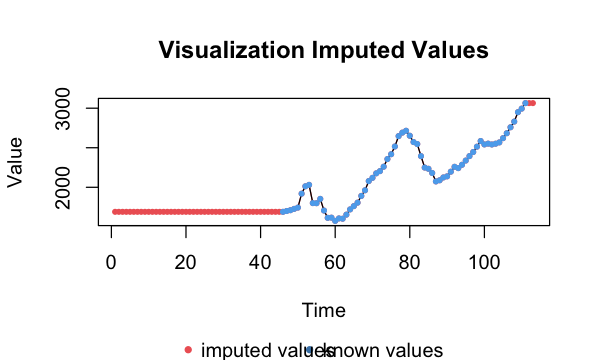

In [10]:
country = 'Bolivia'
variable = 'gdp_pc'
imp = paste0('i', variable)

plotNA.imputations(test[ctry==country, variable, with=FALSE][[1]], 
                   test[ctry==country, imp, with=FALSE][[1]])

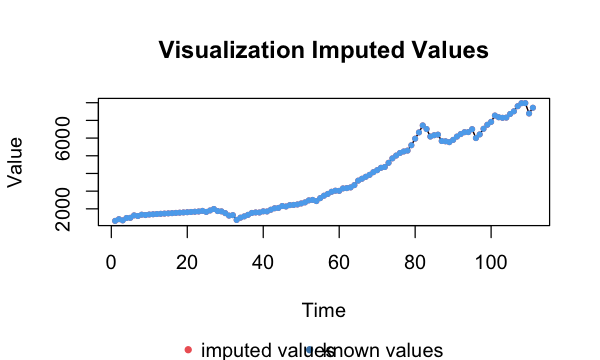

In [11]:
country = 'Mexico'
variable = 'gdp_pc'
imp = paste0('i', variable)

plotNA.imputations(test[ctry==country, variable, with=FALSE][[1]], 
                   test[ctry==country, imp, with=FALSE][[1]])

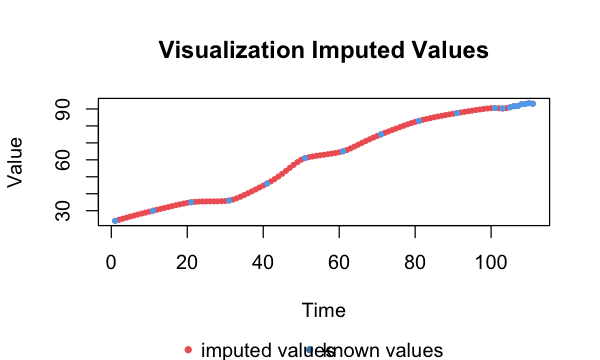

In [12]:
country = 'Mexico'
variable = 'lit'
imp = paste0('i', variable)

plotNA.imputations(test[ctry==country, variable, with=FALSE][[1]], 
                   test[ctry==country, imp, with=FALSE][[1]])

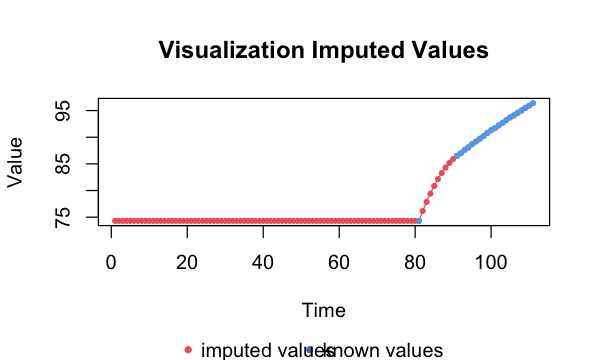

In [13]:
country = 'Argentina'
variable = 'sewage'
imp = paste0('i', variable)

plotNA.imputations(test[ctry==country, variable, with=FALSE][[1]], 
                   test[ctry==country, imp, with=FALSE][[1]])

## Computing log version of variables

- Variables are centered to improve convergence

In [14]:
test[, igdp_log := scale(log(igdp_pc), scale=FALSE, center=TRUE)]
test[, iurban_log := scale(log(iurban), scale=FALSE, center=TRUE)]
test[, ilit_log := scale(log(ilit), scale=FALSE, center=TRUE)]
test[, iwater_log := scale(log(iwater), scale=FALSE, center=TRUE)]
test[, isewage_log := scale(log(isewage), scale=FALSE, center=TRUE)]
test[, ielec_log := scale(log(ielec), scale=FALSE, center=TRUE)]

In [15]:
# time variable
test[, zyear := scale(year, center=TRUE, scale=TRUE)]

# General models 

Important notes: 

- Random intercept by country and year
- Random GDP coefficient by country and year
- All the other covariates are fixed (unique coefficient or beta)
- No interactions between variables

# 1900

- Important: imputation of gdp, urban and literacy via interpolation
- The models I ran are below (i = interpolation, log = nuatural logarithm): 

### No time adjustment 

- igdp_log
- igdp_log + ilit_log 
- igdp_log + iurban_log
- igdp_log + ilit_log + iurban_log 

### (Linear) Time adjustment

- igdp_log + zyear
- igdp_log + ilit_log + zyear
- igdp_log + iurban_log + zyear
- igdp_log + ilit_log + iurban_log + zyear

### Autocorrelation 

- igdp_log
- igdp_log + ilit_log 
- igdp_log + iurban_log
- igdp_log + ilit_log + iurban_log 


Note: name of the dataset `test`

## LE stacking models, 1900+, no time adjustment

In [16]:
# set prior of betas to normal(0,5)
prior = set_prior("normal(0, 5)", class = "b")

In [17]:
m1.1 = brm(formula = wy ~ 1 + igdp_log  + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

Compiling the C++ model
Start sampling


In [18]:
m1.2 = brm(formula = wy ~ 1 + igdp_log  + iurban_log +  (igdp_log|ctry_year), 
          data = test, 
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior)

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


In [19]:
m1.3 = brm(formula = wy ~ 1 + igdp_log  + ilit_log +  (igdp_log|ctry_year), 
          data = test,
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior)

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


In [20]:
m1.4 = brm(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + (igdp_log|ctry_year), 
          data = test, 
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior)

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling
Warning message:
“There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [21]:
loo1.1 = loo(m1.1, reloo=TRUE)
loo1.2 = loo(m1.2, reloo=TRUE)
loo1.3 = loo(m1.3, reloo=TRUE)
loo1.4 = loo(m1.4, reloo=TRUE)

4 problematic observation(s) found.
The model will be refit 4 times.

Fitting model 1 out of 4 (leaving out observation 651)
Start sampling

Fitting model 2 out of 4 (leaving out observation 668)
Start sampling

Fitting model 3 out of 4 (leaving out observation 685)
Start sampling

Fitting model 4 out of 4 (leaving out observation 1728)
Start sampling
2 problematic observation(s) found.
The model will be refit 2 times.

Fitting model 1 out of 2 (leaving out observation 685)
Start sampling

Fitting model 2 out of 2 (leaving out observation 1446)
Start sampling
1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 1443)
Start sampling
1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 1446)
Start sampling


In [30]:
# stacking
loo_list_noyear = list(loo1.1, loo1.2, loo1.3, loo1.4)
weights_models_noyear = as.vector(loo_model_weights(loo_list_noyear))
weights_models_noyear

[1] 1.418130e-02 1.927487e-07 1.591273e-02 9.699058e-01

In [19]:
# # export posterior values 
# s = posterior_samples(m1.1)
# fwrite(s, 'output/posterior_samples_gdp_only.csv')-

In [31]:
models_noyear = list(m1.1, m1.2, m1.3, m1.4)
ps_noyear = list(posterior_samples(m1.1), posterior_samples(m1.2), posterior_samples(m1.3), 
                        posterior_samples(m1.4))

In [32]:
# test_shift_noyear = estimate_shift(models = models_noyear,
#                         ps = ps_noyear,
#                         weights = weights_models_noyear,
#                         data = test, 
#                         country = 'Venezuela', 
#                         cfyear = 2010, 
#                         segment = '1990')

In [33]:
est_shifts_noyear = compute_shifts(models = models_noyear,
                        ps = ps_noyear,
                        weights = weights_models_noyear,
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010))

In [34]:
dim(est_shifts_noyear)

[1] 562000      9

In [35]:
# save file
fwrite(est_shifts_noyear, 'output/shift_1900_stacking.csv')

In [36]:
# gdp only
est_shifts = compute_shifts(models = list(m1.1),
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010))

In [37]:
dim(est_shifts)

[1] 562000      9

In [38]:
fwrite(est_shifts, 'output/shift_1900_gdponly.csv')

## LE stacking models, 1900+, linear adjustment of time

In [39]:
m1.1.year = brm(formula = wy ~ 1 + igdp_log + zyear + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


In [40]:
m1.2.year = brm(formula = wy ~ 1 + igdp_log  + iurban_log + zyear + (igdp_log|ctry_year), 
          data = test, 
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior)

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


In [41]:
m1.3.year = brm(formula = wy ~ 1 + igdp_log  + ilit_log + zyear +  (igdp_log|ctry_year), 
          data = test,
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior)

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


In [42]:
m1.4.year = brm(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + zyear + (igdp_log|ctry_year), 
          data = test, 
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior)


Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


In [ ]:
loo1.1.year = loo(m1.1.year, reloo=TRUE)
loo1.2.year = loo(m1.2.year, reloo=TRUE)
loo1.3.year = loo(m1.3.year, reloo=TRUE)
loo1.4.year = loo(m1.4.year, reloo=TRUE)

2 problematic observation(s) found.
The model will be refit 2 times.

Fitting model 1 out of 2 (leaving out observation 651)
Start sampling

Fitting model 2 out of 2 (leaving out observation 1443)
Start sampling
2 problematic observation(s) found.
The model will be refit 2 times.

Fitting model 1 out of 2 (leaving out observation 651)
Start sampling

Fitting model 2 out of 2 (leaving out observation 1846)
Start sampling


In [ ]:
# stacking
models_year = list(m1.1.year, m1.2.year, m1.3.year, m1.4.year)
ps_year = list(posterior_samples(m1.1.year), posterior_samples(m1.2.year), posterior_samples(m1.3), 
                        posterior_samples(m1.4))

loo_list_year = list(loo1.1.year, loo1.2.year, loo1.3.year, loo1.4.year)
weights_models_year = as.vector(loo_model_weights(loo_list_year))

In [ ]:
test_shift_year = estimate_shift(models = models_year,
                        ps = ps_year,
                        weights = weights_models_year,
                        data = test, 
                        country = 'Venezuela', 
                        cfyear = 2010, 
                        segment = '1990')

In [ ]:
head(test_shift_year)

In [ ]:
est_shifts_year = compute_shifts(models = models_year,
                        ps = ps_year,
                        weights = weights_models_year,
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010))

In [ ]:
head(est_shifts_year)

In [ ]:
dim(est_shifts_year)

In [ ]:
# save file
fwrite(est_shifts_year, 'output/shift_1900_stacking_year.csv')

In [ ]:
# gdp only
est_shifts_year = compute_shifts(models = list(m1.1.year),
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010))

In [ ]:
fwrite(est_shifts_year, 'output/shift_1900_gdponly_year.csv')

## LE individual models, 1900+, autocorrelation adjustment

- These models take so long to run, specially the LOO estimates, so I am not running stacking for these models, just individual outputs. 
- Only gdp only and full model. 

In [54]:
m1.1.auto = brm(formula = wy ~ 1 + igdp_log + (igdp_log|ctry_year), 
          autocor = cor_ar(~wy|ctry, p = 1),      
          data = test, 
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior,
          control=  list(adapt_delta=0.90))

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


In [ ]:
m1.4.auto = brm(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + (igdp_log|ctry_year), 
          autocor = cor_ar(~wy|ctry, p = 1),      
          data = test, 
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior,
          control=  list(adapt_delta=0.90))

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


In [ ]:
est_shifts_out = compute_shifts(models = list(m1.1.auto),
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010))

fwrite(est_shifts_out, 'output/shift_1900_gdponly_autocorrelation.csv')

In [ ]:
est_shifts_out = compute_shifts(models = list(m1.4.auto),
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010))

In [ ]:
fwrite(est_shifts_out, 'output/shift_1900_full_autocorrelation.csv')

# 1950 >

- Important: imputation of electricy, sewage and water is via interpolation
- The models I ran are below (i = interpolation, log = nuatural logarithm): 

### No time adjustment 

- igdp_log
- igdp_log + iwater_log + isewage_log + ielec_log
- igdp_log + ilit_log + iurban_log
- igdp_log + ilit_log + iurban_log + iwater_log + isewage_log + ielec_log

### (Linear) Time adjustment

- igdp_log + zyear
- igdp_log + iwater_log + isewage_log + ielec_log + zyear
- igdp_log + ilit_log + iurban_log + zyear
- igdp_log + ilit_log + iurban_log + iwater_log + isewage_log + ielec_log + zyear

### Autocorrelation 


- igdp_log
- igdp_log + iwater_log + isewage_log + ielec_log
- igdp_log + ilit_log + iurban_log 
- igdp_log + ilit_log + iurban_log + iwater_log + isewage_log + ielec_log 


Note: name of the dataset `test2`

In [ ]:
test2 = test[year>=1950]

In [ ]:
# correlation
cor(test2[, .(igdp_log,iwater_log,isewage_log ,ielec_log)])

## LE stacking models, 1950+, no time adjustment

In [ ]:
# set prior of betas to normal(0,5)
prior = set_prior("normal(0, 5)", class = "b")

In [ ]:
m2.1 = brm(formula = wy ~ 1 + igdp_log + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

In [ ]:
m2.2 = brm(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

In [ ]:
m2.3 = brm(formula = wy ~ 1 + igdp_log + iwater_log + isewage_log + ielec_log + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

In [ ]:
m2.4 = brm(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + iwater_log +
            isewage_log + ielec_log + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

In [ ]:
loo2.1 = loo(m2.1, reloo=TRUE)
loo2.2 = loo(m2.2, reloo=TRUE)
loo2.3 = loo(m2.3, reloo=TRUE)
loo2.4 = loo(m2.4, reloo=TRUE)

In [ ]:
loo_2_list_noyear = list(loo2.1, loo2.2, loo2.3, loo2.4)
weights_models_2_noyear = as.vector(loo_model_weights(loo_2_list_noyear))
weights_models_2_noyear

In [ ]:
models_2_noyear = list(m2.1, m2.2, m2.3, m2.4)
ps_2_noyear = list(posterior_samples(m2.1), posterior_samples(m2.2), posterior_samples(m2.3), 
                        posterior_samples(m2.4))

In [ ]:
est_shifts_noyear = compute_shifts(models = models_2_noyear,
                        ps = ps_2_noyear,
                        weights = weights_models_2_noyear,
                        data = test2, 
                        countries = country_labels, 
                        years = c(1970, 1990, 2010))

In [ ]:
dim(est_shifts_noyear)

In [ ]:
head(est_shifts_noyear)

In [ ]:
# save file
fwrite(est_shifts_noyear, 'output/shift_1950_stacking.csv')

## LE stacking models, 1950+, time adjustment

In [ ]:
m2.1.year = brm(formula = wy ~ 1 + igdp_log + zyear + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

In [ ]:
m2.2.year = brm(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + zyear + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

In [ ]:
m2.3.year = brm(formula = wy ~ 1 + igdp_log + iwater_log + isewage_log + ielec_log + zyear + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

In [ ]:
m2.4.year = brm(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + iwater_log +
            isewage_log + ielec_log + zyear + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

In [ ]:
loo2.1.year = loo(m2.1.year, reloo=TRUE)
loo2.2.year = loo(m2.2.year, reloo=TRUE)
loo2.3.year = loo(m2.3.year, reloo=TRUE)
loo2.4.year = loo(m2.4.year, reloo=TRUE)

In [ ]:
loo_2_list_year = list(loo2.1.year, loo2.2.year, loo2.3.year, loo2.4.year)
weights_models_2_year = as.vector(loo_model_weights(loo_2_list_year))
weights_models_2_year

In [ ]:
models_2_year = list(m2.1.year, m2.2.year, m2.3.year, m2.4.year)
ps_2_year = list(posterior_samples(m2.1.year), posterior_samples(m2.2.year), posterior_samples(m2.3.year), 
                        posterior_samples(m2.4.year))

In [ ]:
est_shifts_year = compute_shifts(models = models_2_year,
                        ps = ps_2_year,
                        weights = weights_models_2_year,
                        data = test2, 
                        countries = country_labels, 
                        years = c(1970, 1990, 2010))

In [ ]:
head(est_shifts_year)

In [ ]:
dim(est_shifts_year)

In [ ]:
# save file
fwrite(est_shifts_year, 'output/shift_1950_stacking_year.csv')

## LE individual models, 1950+, autocorrelation adjustment

In [ ]:
m2.1.auto = brm(formula = wy ~ 1 + igdp_log + (igdp_log|ctry_year), 
          autocor = cor_ar(~wy|ctry, p = 1),      
          data = test, 
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior,
          control=  list(adapt_delta=0.90))

In [ ]:
m2.4.auto = brm(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + iwater_log +
            isewage_log + ielec_log + (igdp_log|ctry_year), 
          autocor = cor_ar(~wy|ctry, p = 1),      
          data = test, 
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior,
          control=  list(adapt_delta=0.90))

In [ ]:
est_shifts_out = compute_shifts(models = list(m2.1.auto),
                        data = test2, 
                        countries = country_labels, 
                        years = c(1970, 1990, 2010))

fwrite(est_shifts_out, 'output/shift_1950_gdponly_autocorrelation.csv')

In [ ]:
dim(est_shifts_out)

In [ ]:
est_shifts_out = compute_shifts(models = list(m2.4.auto),
                        data = test2, 
                        countries = country_labels, 
                        years = c(1970, 1990, 2010))

fwrite(est_shifts_out, 'output/shift_1950_full_autocorrelation.csv')

In [ ]:
dim(est_shifts_out)

In [ ]:
head(est_shifts_out)